This notebook includes code to work with the filtered database to pre-process the signals within the filtered database so that the signals are ready for analysis

In [1]:
%run "Database_Filtering.ipynb" #allowing access to the filtered database

  0%|                                                                                          | 0/549 [00:00<?, ?it/s]

Filtering Database


100%|████████████████████████████████████████████████████████████████████████████████| 549/549 [01:31<00:00,  6.03it/s]

221 remaining out of 290


First we need to access all the signals within the filtered database

In [2]:
no_patients = allowed_patients.count_patients()

#currently only does v1
signals = np.zeros(shape=(no_patients, sample_length))
for i in tqdm(range(0, no_patients)):
    signal = allowed_patients.get_patients(i).read_signal(['v1']).reshape(-1)
    signals[i] = signal

100%|████████████████████████████████████████████████████████████████████████████████| 221/221 [00:02<00:00, 94.43it/s]


In [331]:
#stating the signal to be used throughout this notebook for easy comparisson
experimental_signal_indice = 9 #8
experminetal_channel_indice = 0

Before the reduction of noise can begin we need to ensure all the signals are inverted correctly. To do this I have used....

In [332]:
# inversion_corrected_signals = np.zeros(shape=(no_patients, sample_length))
# flip_state_list = []
# for i in range(0, len(signals)):
#     inversion_corrected_signals[i], flip_state = nk.ecg_invert(signals[i])
#     flip_state_list.append(flip_state)

In [333]:
signals = inversion_corrected_signals

The first step is to try to repeat the pre-processing done within the paper mentioned within my proposal:
https://www.nature.com/articles/s41598-017-15498-z#Bib1

## Polynomial Detrending

In [334]:
def polynomial_detrending(signal, degree):
    x = np.linspace(0, len(signal), len(signal))
    
    coeffs = np.polyfit(x, signal, degree)
    trend = np.polyval(coeffs, x)
    
    return np.array(signal).reshape(-1) - np.array(trend), trend

In [335]:
detrended_signals = np.zeros(shape=(no_patients, sample_length))
trends = np.zeros(shape=(no_patients, sample_length))
for i in range(0, no_patients):
    detrended_signals[i], trends[i] = polynomial_detrending(signals[i], 8)
    
    

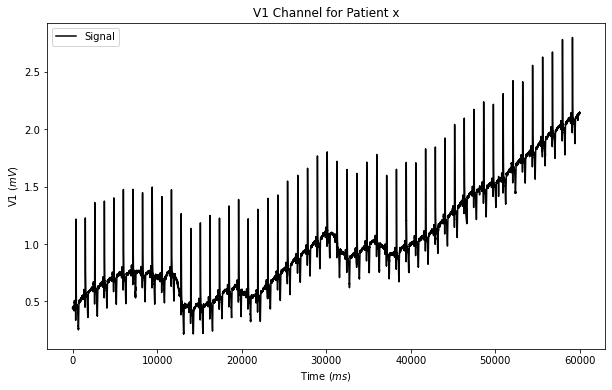

In [336]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))


ax.plot(signals[experimental_signal_indice], color = 'black', label = 'Signal')
#ax.plot(detrended_signals[experimental_signal_indice], color = 'red', label = 'detrended sig')
#ax.plot(trends[experimental_signal_indice])

ax.set_xlabel(r'Time ($ms$)')
ax.set_ylabel(r'V1 ($mV$)')
ax.set_title('V1 Channel for Patient x')

ax.legend()
plt.show()

In [337]:
#can use other methods for the fitting?? rbf etc, always gonna have issues with this as shown above, can increase fitting
#degree but comes with other errors

## Wavelet Detrending  - Discrete

Decomposes the signal into discrete wavelets seperated by different frequency bands, from low frequency to high frequency.
Low frequency components include the trend of the signal so setting these to zero is baseline removal
High frequency components include more detail, so be removing these may be removing noise associated bands 
- can do a hard cut off by just not including these levels or a soft threshold where threshold given by : $\sigma \sqrt{2*log(n)}$ where $\sigma$ is the noise std dev ( 6 in A/D units) and n is the sample number.

In [338]:
import pywt

In [339]:
coeffs = pywt.wavedec(signals[experimental_signal_indice], wavelet='db4')  #does level include only that many or just decompose to that many??

set_to_zero = [0, 1, 2, 3, 4]
level_to_zero = 9
for i in range(0, len(coeffs)):
    if i in set_to_zero or i > level_to_zero:
        coeffs[i] = np.zeros_like(coeffs[i])


detrended_signal_wavelet = pywt.waverec(coeffs, wavelet='db4')

In [340]:
def soft_thresholding(x, threshold):
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)


#calculating threshold using universal threshold???
noise_std_dev = 6 #A/D
threshold = noise_std_dev * np.sqrt(2 * np.log(len(signals[0])))
threshold = 0.1
   
#recalculate for comparisson
coeffs1 =  pywt.wavedec(signals[experimental_signal_indice], wavelet='db4')

# applying soft thresholding to the detail coefficients
coeffs1[0] = np.zeros_like(coeffs1[0]) # set to zero to remove baseline
for i, detail_coeff in enumerate(coeffs1[1:]):
    coeffs1[i+1] = soft_thresholding(detail_coeff, threshold)
                                              
detrended_signal_wavelet_soft = pywt.waverec(coeffs1, wavelet='db4')

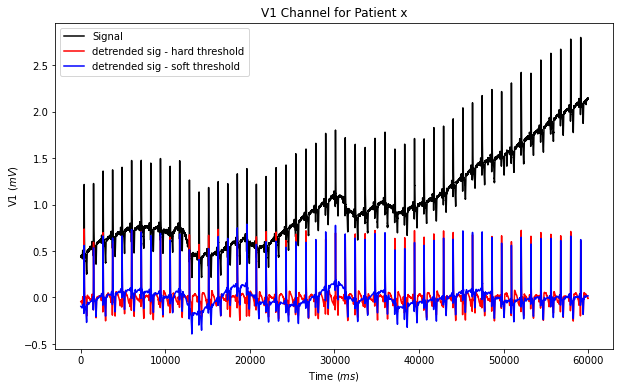

In [341]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))


splice = (0, 6000)
ax.plot(signals[experimental_signal_indice][:60000], color = 'black', label = 'Signal')
ax.plot(detrended_signal_wavelet[:60000], color = 'red', label = 'detrended sig - hard threshold')
ax.plot(detrended_signal_wavelet_soft[:60000], color = 'blue', label = 'detrended sig - soft threshold')

ax.set_xlabel(r'Time ($ms$)')
ax.set_ylabel(r'V1 ($mV$)')
ax.set_title('V1 Channel for Patient x')

ax.legend()
plt.show()

Need to balance signal denoising with preservation of signal features

## Wavelet detrending - continuous

need to look into appropriate wavelets and scale ranges cuz large scale range takes long time and alot of memory

In [342]:
#chose specific wavelet for problem
wavelet = 'morl'

#define scale range based on frequency range desired currently 1-50 hz 
scales = np.arange(24, 500)

#continous wt - commented out cuz takes ages
#coefficients, frequencies = pywt.cwt(signal, scales, wavelet)

In [343]:
#visualisation
# plt.imshow(np.abs(coefficients), extent=[0, len(signal), 24, 500], cmap='PRGn', aspect='auto',
#            vmax=abs(coefficients).max(), vmin=-abs(coefficients).max())
# plt.colorbar(label='Magnitude')
# plt.ylabel('Scale')
# plt.xlabel('Time')
# plt.title('Continuous Wavelet Transform (CWT)')
# plt.show()

## Butterworth filter

In [344]:
from scipy.signal import butter, filtfilt

In [345]:
# Define the cutoff frequency for the Butterworth filter
cutoff_freq = 1# Adjust this value based on the characteristics of your signal

# Normalize the cutoff frequency
nyquist_freq = 500  # Nyquist frequency is half the sampling frequency
normalized_cutoff = cutoff_freq / nyquist_freq

# Design a low-pass Butterworth filter
order = 3  # Filter order
b, a = butter(order, normalized_cutoff, btype='low')

# Apply the filter to detrend the signal
detrended_signal_butter = filtfilt(b, a, signals[experimental_signal_indice])#thought this would give the detrended signal but gives a very good fit here
detrended_signal = signals[experimental_signal_indice]-detrended_signal_butter

#normalising signal
norm_detrended_signal = (detrended_signal - detrended_signal.min())/(detrended_signal.max()-detrended_signal.min()) 

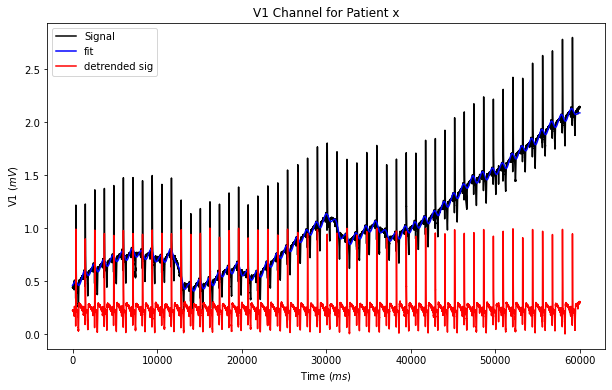

In [346]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))


ax.plot(signals[experimental_signal_indice], color = 'black', label = 'Signal')
ax.plot(detrended_signal_butter, color = 'blue', label = 'fit')
ax.plot(norm_detrended_signal, color = 'red', label = 'detrended sig')

ax.set_xlabel(r'Time ($ms$)')
ax.set_ylabel(r'V1 ($mV$)')
ax.set_title('V1 Channel for Patient x')

ax.legend()
plt.show()

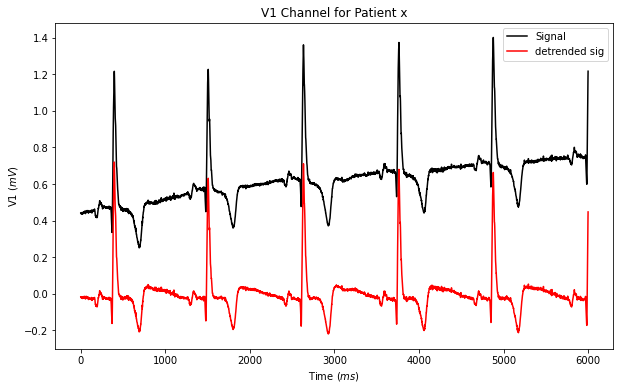

In [347]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))


ax.plot(signals[experimental_signal_indice][:6000], color = 'black', label = 'Signal')
#ax.plot(detrended_signal_butter[:6000], color = 'red', label = 'fit')
ax.plot(detrended_signal[:6000], color = 'red', label = 'detrended sig')

ax.set_xlabel(r'Time ($ms$)')
ax.set_ylabel(r'V1 ($mV$)')
ax.set_title('V1 Channel for Patient x')

ax.legend()
plt.show()

In [348]:
def butterworth_detrending(signal, cut_off_freq, nyquist_freq, order):
    normalised_cut_off = cut_off_freq/nyquist_freq
    
    b, a = butter(order, normalized_cutoff, btype='low')

    baseline = filtfilt(b, a, signal)#thought this would give the detrended signal but gives a very good fit here
    detrended_signal = signal-baseline
    return detrended_signal, baseline

#need to implement a low and high pass filter, high pass removes baseline wander (e.g. cut_off = 0.1)
#low pass removes high frequency noise e.g cut_off 1.0

In [349]:
butterworth_detrended_signals = np.zeros(shape=(no_patients, sample_length))
trends = np.zeros(shape=(no_patients, sample_length))

for i, signal in enumerate(signals):
    butterworth_detrended_signals[i], trends[i] = butterworth_detrending(signal, cutoff_freq, nyquist_freq, order)

## Gaussian smoothing

In [350]:
from scipy.ndimage import gaussian_filter1d

In [351]:
sigma = 4  # standard dev of the Gaussian kernel - find reason to chose this other than just trial and error
smoothed_signal = gaussian_filter1d(signals[experimental_signal_indice], sigma)


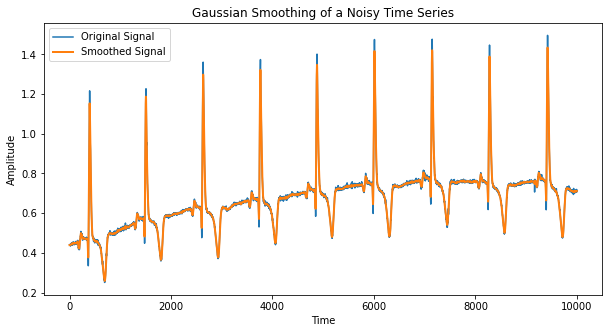

In [352]:
plt.figure(figsize=(10, 5))
plt.plot(signals[experimental_signal_indice][:10000], label='Original Signal')
plt.plot(smoothed_signal[:10000], label='Smoothed Signal', linewidth=2)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Gaussian Smoothing of a Noisy Time Series')
plt.show()

## Power Spectrum Analysis

Fast Fourier Transform (FFT) vs Short-time Fourier Transform (STFT)

STFT:
- provides both time and frequency information, allowing for the analysis of how the frequency content of a signal changes over time - not needed here?
- Suitable for non-stationary signals where frequency characteristics change over time - relevant to ECG
- more computationally intensive than FFT

FFT:
- Highly efficient, so used often for large datasets
- however assumes the signal is stationary
- does not provide specific time information


In [353]:
#fast fourier transform
sample_freq = 1000 #Hz, sampling freq in PTB diagnostic database

freq_domain = np.fft.fft(signals[experimental_signal_indice])
freqs = np.fft.fftfreq(len(signals[experimental_signal_indice]), d=1/sample_freq)


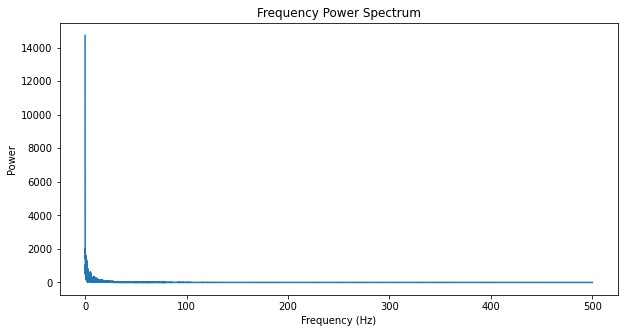

In [354]:
# Plot the power spectrum - plotting just the positive frequencies as is symmetric so negative freqs meaningless
plt.figure(figsize=(10, 5))
plt.plot(freqs[freqs>0], np.abs(freq_domain[freqs>0]))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('Frequency Power Spectrum')
plt.show()

## Fixed Butterworth

In [355]:
#high-pass filter removes baseline wander
def butter_highpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

cutoff_frequency = 0.5  # Cutoff frequency in Hz (remove frequencies below this)
b, a = butter_highpass(cutoff_frequency, sample_freq)
baseline_removed_signal = filtfilt(b, a, signals[experimental_signal_indice])

#band-pass filter to remove noise
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

lowcut = 1 # Lower bound of the band-pass filter
highcut = 50  # Upper bound of the band-pass filter
b, a = butter_bandpass(lowcut, highcut, sample_freq)
denoised_signal = filtfilt(b, a, baseline_removed_signal)

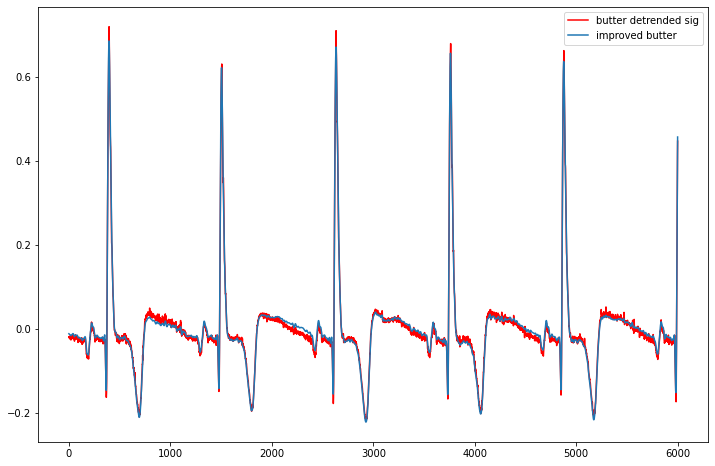

In [356]:
fig, axes = plt.subplots(figsize = (12,8))

axes.plot(detrended_signal[:6000], color = 'red', label = 'butter detrended sig')
axes.plot(denoised_signal[:6000], label = 'improved butter')
#axes.plot(signals[experimental_signal_indice][:6000])


#axes.plot(detrended_signal_wavelet[:6000], color = 'blue', label = 'wavelet detrended sig')
axes.legend()
plt.show()

this butterworth filter works now, can get the bounds from the power spectrum analysis - decide which one to use then write up in report then data preprocessing section done.

## Comparrison of detrended signals

Unhealthy


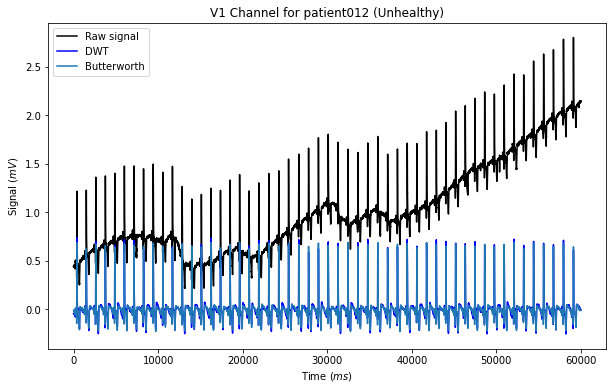

In [358]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))

#finding actual patient numbers from within database
names = []
for i in range(0, no_patients):
    names.append(allowed_patients.get_patients(i).get_name())

health = allowed_patients.get_patients(i).get_health_state()
print(health)

time_stop = 60000

ax.plot(signals[experimental_signal_indice][:time_stop], color = 'black', label = 'Raw signal')
#ax.plot(detrended_signal[:6000], color = 'red', label = 'butter detrended sig')
ax.plot(detrended_signal_wavelet[:time_stop], color = 'blue', label = 'DWT')
ax.plot(denoised_signal[:time_stop], label = 'Butterworth')

ax.set_xlabel(r'Time ($ms$)')
ax.set_ylabel(r'Signal ($mV$)')
ax.set_title(f'V1 Channel for {names[experimental_signal_indice]} ({health})')

ax.legend()
plt.show()

can get good denoised signal with DWT but need actual reason to set some to zero and keep some coeffs -- found in paper
still only done on one channel

### looking at ecg_clean

0        0.68468
1        0.68468
2        0.68468
3        0.68468
4        0.68468
          ...   
59995    0.00000
59996    0.00000
59997    0.00000
59998    0.00000
59999    0.00000
Name: ECG_Quality, Length: 60000, dtype: float64


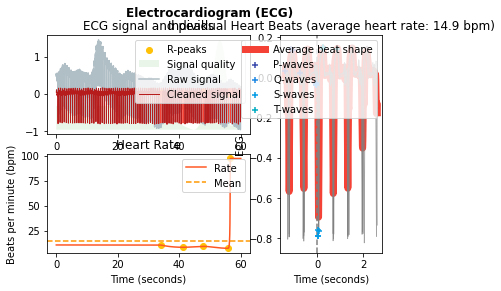

In [94]:
import neurokit2 as nk

results, info = nk.ecg_process(signals[experimental_signal_indice])

nk.ecg_plot(results, info)
print(results['ECG_Quality'])
clean_signal = results['ECG_Clean']

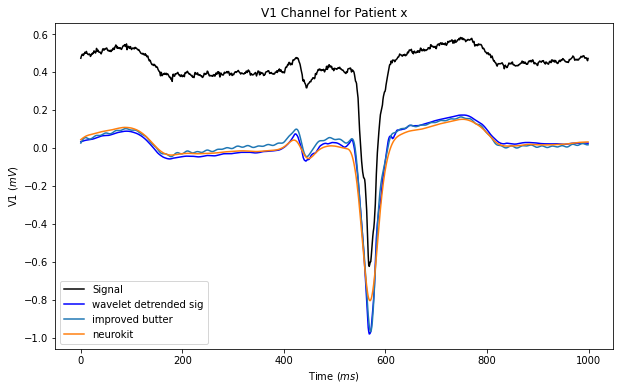

In [95]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))


ax.plot(signals[experimental_signal_indice][:1000], color = 'black', label = 'Signal')
#ax.plot(detrended_signal[:6000], color = 'red', label = 'butter detrended sig')
ax.plot(detrended_signal_wavelet[:1000], color = 'blue', label = 'wavelet detrended sig')
ax.plot(denoised_signal[:1000], label = 'improved butter')
ax.plot(clean_signal[:1000], label = 'neurokit')

ax.set_xlabel(r'Time ($ms$)')
ax.set_ylabel(r'V1 ($mV$)')
ax.set_title('V1 Channel for Patient x')

ax.legend()
plt.show()

### checking for signal inversion

(array([-0.05094032, -0.04894032, -0.04844032, ..., -0.07244032,
        -0.07144032, -0.07244032]),
 True)

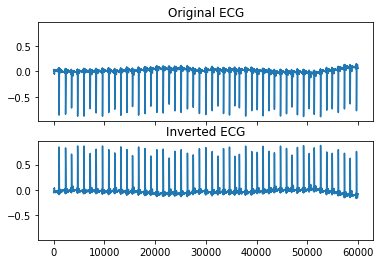

In [96]:
nk.ecg_invert(signals[208], show=True)

In [97]:
inversion_corrected_signals = np.zeros(shape=(no_patients, sample_length))
flip_state_list = []
for i in range(0, len(signals)):
    inversion_corrected_signals[i], flip_state = nk.ecg_invert(signals[i])
    flip_state_list.append(flip_state)

KeyboardInterrupt: 

In [ ]:
print(flip_state_list)
print(len([i for i, state in enumerate(flip_state_list) if state == True]))

### checking signal quality

In [ ]:
quality = nk.ecg_quality(clean_signal, method='zhao2018')
print(quality)

signal_quality = []
for i in range(0, len(signals)):
    cleaned_signal = nk.ecg_clean(signals[i])
    quality = nk.ecg_quality(cleaned_signal, method='zhao2018')
    signal_quality.append(quality)

In [ ]:
print(signal_quality)
print([i for i, quality in enumerate(signal_quality) if quality == 'Unacceptable'])
print(len([i for i, quality in enumerate(signal_quality) if quality == 'Unacceptable']))

In [ ]:
signal_quality = []
for i in range(0, len(signals)):
    cleaned_signal = nk.ecg_clean(inversion_corrected_signals[i])
    quality = nk.ecg_quality(cleaned_signal, method='zhao2018')
    signal_quality.append(quality)

In [ ]:
print(signal_quality)
print([i for i, quality in enumerate(signal_quality) if quality == 'Unacceptable'])
print(len([i for i, quality in enumerate(signal_quality) if quality == 'Unacceptable']))

## Investigating Power Spectrum of denoised signal

In [ ]:
#butterworth detrended signals
butter_freq_domain = np.fft.fft(denoised_signal)
butter_freqs = np.fft.fftfreq(len(denoised_signal), d=1/sample_freq)

wavelet_freq_domain = np.fft.fft(detrended_signal_wavelet)
wavelet_freqs = np.fft.fftfreq(len(detrended_signal_wavelet), d=1/sample_freq)

In [ ]:
# comparisson of power spectrum 
plt.figure(figsize=(10, 5))
#plt.plot(wavelet_freqs[wavelet_freqs>0], np.abs(wavelet_freq_domain[wavelet_freqs>0]), alpha=0.3)
plt.plot(butter_freqs[butter_freqs>0], np.abs(butter_freq_domain[butter_freqs>0]), alpha=0.3)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('Frequency Power Spectrum')
plt.show()

## Recreate violin plot from paper 
- do on filtered data

In [ ]:
# computing FFT and finding the frequency with the maximum power for each signal
max_power_frequencies = np.zeros(shape = no_patients)

for i in tqdm(range(0, no_patients)):
    fft_domain = np.fft.fft(signals[i])
    fft_freq = np.fft.fftfreq(len(signals[i]), 1/sample_freq)
    power_spectrum = np.abs(fft_domain)**2
    
    # Find the frequency with the maximum power
    positive_freqs = fft_freq >= 0
    max_power_freq = fft_freq[positive_freqs][np.argmax(power_spectrum[positive_freqs])]
    max_power_frequencies[i] = max_power_freq
    

    

In [ ]:
import seaborn as sn #for violin plot, use matplotlib

health_state = allowed_patients.get_diagnoses()
print(type(max_power_frequencies[0]))
encoded_health_state = [True if label == 'Unhealthy' else False for label in health_state]
healthy_freq = max_power_frequencies[~np.array(encoded_health_state)]
unhealthy_freq = max_power_frequencies[encoded_health_state]

fig, ax = plt.subplots(figsize = (8, 6))
sn.violinplot(max_power_frequencies, inner="points", orient='v', ax=ax)
ax.set_title('Distribution of Frequencies with Maximum Power')
ax.set_xlabel('Signal Index')
ax.set_ylabel('Frequency [Hz]')
plt.show()

In [ ]:
import pandas as pd
fig, ax = plt.subplots()

# Prepare the data for Seaborn
df1 = pd.DataFrame({
    'frequency': max_power_frequencies,
    'health state': health_state
})

# Create the violin plot
#sn.violinplot(data=df1, x="health state", y="frequency")
ax.set_title('Distribution of Frequencies with Maximum Power')
ax.set_xlabel('Health State')
ax.set_ylabel('Frequency [Hz]')
plt.show()

#violin plot from seaborn very buggy


In [ ]:
from scipy.signal import stft

# params
fs = 1000  # sampling frequency
window_size = 256  # Window size - in sample number
overlap = 128  # Overlap between windows - in sample number, so 50% trade off between smoothness and computational time
#window_type = 'hamming'  # or 'hamming'


#returns frequencies, times and complex STFT values
frequencies, times, Zxx = stft(signals[experimental_signal_indice], fs, nperseg=window_size, noverlap=overlap)

# Plot STFT magnitude
plt.figure(figsize=(12, 6))
plt.pcolormesh(times, frequencies, np.abs(Zxx), shading='gouraud')
plt.title('STFT Magnitude of ECG Signal')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Magnitude')
plt.show()

#do individual basis and healthy/non healthy
#have a look at power spectrum analysis
#have a look at R-R interval

In [ ]:
#try and recreate the plot from the paper - do we do this in this file or in parameter one??
#try to determine what cutoffs to use for the butterworth filters from the power spectra

In [ ]:
# import matplotlib.animation as animation

# %matplotlib notebook
# fig, ax = plt.subplots(1, 1, figsize = (10, 6))

# def update(index):
#     ax.clear()  # Clear the previous plot
#     ax.plot(signals[index], color='black', label='Signal')
#     ax.plot(denoised_signals[index], color='red', label='Denoised Signal')
#     ax.legend()
#     ax.set_title(f'Signal {index}')

# # Create animation
# ani = animation.FuncAnimation(fig, update, frames=no_patients, interval=3000)  # 10000 ms interval (10 seconds)

# plt.show()